Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 2 Classification

## Section 1: Data Preparation

Talk about data prep here.

[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

In [7]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

In [8]:
# read in the data
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


In [9]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_df.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_df.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_df = runs_df_onehot.reset_index(drop=True)

[5 points] Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

## Section 2: Modeling and Evaluation

[10 points] Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

Our primary metric for evaluating model performance is Area Under the Curve (AUC). AUC score provides a good balance between accuracy, specificity, and sensitivity. In an unbalanced data set such as this one, you cannot rely on accuracy alone. 

Since 92% of the observations in the data set are losers, creating a "model" that predicts a loss for every observation would have an accuracy of 92% but offer no practical use.

[10 points] Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate.

For dividing our test and train data sets we used 10-fold Stratified Cross Validation (CV). In 10-fold CV, the data set is divided into 10 groups where one becomes the hold out (test) set and the other 9 become the training data. In Stratified CV, the proportion of observations is preserved in each fold. There are many more losers than winners in this data set. Therefore, preserving the proportion of winners to losers in each fold is important to ensure you do not accidentally create a test set of all losers.

In [10]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head(10)

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,0,0,0,1,0,0,0,0,0,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,0,0,0,1,0,0,0,0,0,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,0,0,0,1,0,0,0,0,0,0
5,5,0,6,3296,3,0.0,1.25,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,1
6,6,0,7,911,12,0.0,9.50,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
7,7,0,8,2170,1,1.0,0.00,3,AUS,Gelding,...,0,0,0,1,0,0,0,0,0,1
8,8,0,9,1730,13,0.0,9.75,3,NZ,Gelding,...,0,0,0,1,0,0,0,0,0,0
9,9,0,10,2998,14,0.0,999.00,3,AUS,Mare,...,0,0,0,0,0,0,1,0,0,0


In [11]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
runs_data.head()

,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Example on how to scale, model, and get metrics while using cross validation with a pipeline
## Example also shows how to use this to tune a tune a hyper-parameter

#### Possible adjustments you should look at
- The parameter being hypertuned and values at the start of the loop
- Is the scaler type what you want
- Is the model information updated
- The cross_validate() function uses runs_data and runs_target to check for win. You need to unpdate to runs_target2 to check for show
- You should also update the first print statement to reflect your hyperparameter name
- This should be applied to all models so we are consistent because original method was not fully utilizing all splits

In [13]:
#Referenced website: https://machinelearningmastery.com/data-preparation-without-data-leakage/
Kvals = [5,10,15,20,25]
for k in Kvals:
    # define the pipeline
    steps = list()
    steps.append(('scaler', StandardScaler()))
    steps.append(('model', KNeighborsClassifier(n_neighbors=k, weights='distance', metric='euclidean')))
    pipeline = Pipeline(steps=steps)

    # define the evaluation procedure
    cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

    #Modeling with pipeline and scoring with cross_validate()
    scores = cross_validate(pipeline, runs_data, runs_target, scoring=['roc_auc','accuracy','precision'],
                             cv=cv, return_train_score=False)
    print('When k =',k)
    print('   Mean Precision: ',np.mean(scores['test_precision']))
    print('   Mean AUC: ',np.mean(scores['test_roc_auc']))
    print('   Mean Accuracy: ',np.mean(scores['test_accuracy']))
    print('   Mean Time per Split: ',np.mean(scores['fit_time'])+np.mean(scores['score_time']))
    print(' ')

When k = 5
   Mean Precision:  0.1707903968285776
   Mean AUC:  0.6037496094198885
   Mean Accuracy:  0.9109474346868114
   Mean Time per Split:  60.10656623840332
 
When k = 10
   Mean Precision:  0.19799228641036284
   Mean AUC:  0.6449143833331827
   Mean Accuracy:  0.9179792256846081
   Mean Time per Split:  60.38502929210663
 
When k = 15
   Mean Precision:  0.21956862876052713
   Mean AUC:  0.6656412889660149
   Mean Accuracy:  0.9192760465848284
   Mean Time per Split:  63.37887809276581
 
When k = 20
   Mean Precision:  0.14989177489177488
   Mean AUC:  0.6770072562898461
   Mean Accuracy:  0.9196285804217814
   Mean Time per Split:  63.42254602909088
 
When k = 25
   Mean Precision:  0.18666666666666668
   Mean AUC:  0.6841538393917366
   Mean Accuracy:  0.9197922568460812
   Mean Time per Split:  69.5132155418396
 


### All references to the below three cells should be removed as this will be deleted

In [16]:
# CV for the 'show' target
cv_Show = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx_Show, testidx_Show in cv.split(runs_data,runs_target2):
    # note that these are sparse matrices
    X_train_Show,X_test_Show = runs_data.iloc[trainidx_Show], runs_data.iloc[testidx_Show] 
    Y_train_Show, Y_test_Show = runs_target.iloc[trainidx_Show], runs_target.iloc[testidx_Show]

In [5]:
# CV for the 'won' target
cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, train_size=0.8, random_state = 0)

# fill in the training and testing data and save as separate variables
for trainidx, testidx in cv.split(runs_data,runs_target):
    # note that these are sparse matrices
    X_train,X_test = runs_data.iloc[trainidx], runs_data.iloc[testidx] 
    Y_train, Y_test = runs_target.iloc[trainidx], runs_target.iloc[testidx]

In [17]:
scl_obj = StandardScaler()
X_train = scl_obj.fit_transform(X_train, y = None)
X_test = scl_obj.fit_transform(X_test, y = None)

scl_obj = StandardScaler()
X_train_Show = scl_obj.fit_transform(X_train_Show, y = None)
X_test_Show = scl_obj.fit_transform(X_test_Show, y = None)

### Section 2.1: Model 1 - K-Nearest Neighbors

K-Nearest Neighbors is an algorithm frequently used for classification. In order to classify an observation, the algorithm measures the distance from the given observation to it's K nearest neighbors, where K is a tunable parameter.

For each iteration of the model fitting, we try a different K value and print out the model precision and AUC score. Because the data set is not balanced, we use AUC as the primary metric for comparing model performance. If we used accuracy, we could achieve an accuracy of over 90% simply by classifying every observation as a "los", but this has no practical use so we use Precision as a secondary metric instead.

First, we implemented two models. Both use Euclidean distance but one uses a uniform weight and the other uses distance. For uniform weight, all the nearest neighbors have the same impact in classification. In distance, closer neighbors have more impact.

The difference in model performance for uniform vs. distance was negligable, but the model with weights='distance' trained more quickly so we elected to use that parameter.

#### Euclidean Distance, Uniform Weights

In [7]:
# Use Euclidean distance and iterate over several K-values
## ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
Kvals = [3,5,7,9,11,13,15,17,19,21]
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='uniform', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.170  AUC: 0.515
Precision of classifier with 5 neighbors is: 0.156  AUC: 0.505
Precision of classifier with 7 neighbors is: 0.244  AUC: 0.505
Precision of classifier with 9 neighbors is: 0.279  AUC: 0.504
Precision of classifier with 11 neighbors is: 0.227  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.273  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.333  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision of classifier with 17 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision of classifier with 19 neighbors is: 0.000  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Euclidean Distance, Distance Weights

In [8]:
# Use Euclidean distance - sqrt(sum((x - y)^2))
## ‘distance’ : weight points by the inverse of their distance. 
##    in this case, closer neighbors of a query point will have a greater 
##    influence than neighbors which are further away.

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)    

Precision of classifier with 3 neighbors is: 0.178  AUC: 0.520
Precision of classifier with 5 neighbors is: 0.175  AUC: 0.509
Precision of classifier with 7 neighbors is: 0.250  AUC: 0.509
Precision of classifier with 9 neighbors is: 0.258  AUC: 0.505
Precision of classifier with 11 neighbors is: 0.263  AUC: 0.503
Precision of classifier with 13 neighbors is: 0.238  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.250  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.500  AUC: 0.501
Precision of classifier with 19 neighbors is: 1.000  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The next parameter we experimented with was the weight metric. We re-ran the model several times using different metrics from the sklearn DistanceMetric library, to include Manhatten and Chebyshev.

Again, the model performance for the different metrics was negligable so we elected to use Euclidean distance since it is well optimized for large data sets.

#### Manhatten Distance

In [9]:
# Use Manhatten distance - sum(|x - y|)

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.189  AUC: 0.521
Precision of classifier with 5 neighbors is: 0.207  AUC: 0.511
Precision of classifier with 7 neighbors is: 0.250  AUC: 0.507
Precision of classifier with 9 neighbors is: 0.250  AUC: 0.504
Precision of classifier with 11 neighbors is: 0.333  AUC: 0.504
Precision of classifier with 13 neighbors is: 0.364  AUC: 0.503
Precision of classifier with 15 neighbors is: 0.286  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.250  AUC: 0.500
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Chebyshev Distance

In [10]:
# Use ChebyshevDistance distance - max(|x - y|)

for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')
    clf_knn.fit(X_train,Y_train)
    yhat= clf_knn.predict(X_test)
    acc = mt.accuracy_score(Y_test,yhat)
    prec = mt.precision_score(Y_test,yhat)
    auc = roc_auc_score(Y_test,yhat)
    conf = mt.confusion_matrix(Y_test,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.160  AUC: 0.516
Precision of classifier with 5 neighbors is: 0.196  AUC: 0.511
Precision of classifier with 7 neighbors is: 0.200  AUC: 0.505
Precision of classifier with 9 neighbors is: 0.217  AUC: 0.503
Precision of classifier with 11 neighbors is: 0.200  AUC: 0.502
Precision of classifier with 13 neighbors is: 0.200  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.333  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.500  AUC: 0.500
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.500  AUC: 0.500


With each of the KNN models above, the precision and AUC tend to stabilize at around k=9 or 11. Note as the K value increases so too does the precision but the AUC decreases. Choosing a smaller K-value such as 7 produces a good balace between the different metrics.

We fit a final KNN using the parameters selected: Euclidean, Distance weights for neighbors, and 7 neighbors.

#### KNN with Euclidean, Distance weight, and K=7 neighbors

In [22]:
# Based on above, Euclidean with K=7 is a good combination of precision and AUC
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 7 neighbors is: 0.250  AUC: 0.509


Below is the Confusion Matrix plotted for the model. As can be seen, it classified the majority of observations as loses (correctly). This makes sense since about 92% of the data set are horses who did not win their race.

#### Confusion Matrix for KNN Model

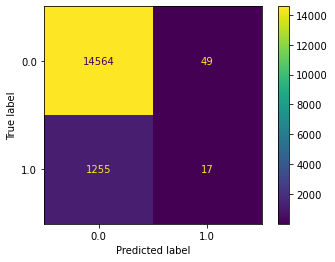

In [12]:
plot_confusion_matrix(clf_knn, X_test, Y_test)

In [23]:
# I tried several different algorithm parameters here (e.g. kd_tree, ball_tree) without effect
x=7
clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean', algorithm='kd_tree')
clf_knn.fit(X_train,Y_train)
yhat= clf_knn.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat)
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 7 neighbors is: 0.250  AUC: 0.509


From the Confusion Matrix above, notice the large number of false positives. The model incorrectly classified over 1000 observations as wins when they should have been loses. It only correctly classified about 50 wins. Since this data set is results of horse races, you can assume an interested party would be a gambler. The KNN model would not be of much benefit to a gambler due to the large number of Type I error in proportion to true positive results.

#### Predict Show Horses

Next we generated several more KNN models where we predicted Show instead of Win. We tried several different metrics of measure and K values.

#### Euclidean distance for Show

In [24]:
# Use Euclidean distance
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='euclidean')
    clf_knn.fit(X_train_Show,Y_train_Show)
    yhat= clf_knn.predict(X_test_Show)
    acc = mt.accuracy_score(Y_test_Show,yhat)
    prec = mt.precision_score(Y_test_Show,yhat)
    auc = roc_auc_score(Y_test_Show,yhat)
    conf = mt.confusion_matrix(Y_test_Show,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.127  AUC: 0.510
Precision of classifier with 5 neighbors is: 0.113  AUC: 0.503
Precision of classifier with 7 neighbors is: 0.137  AUC: 0.503
Precision of classifier with 9 neighbors is: 0.180  AUC: 0.502
Precision of classifier with 11 neighbors is: 0.222  AUC: 0.502
Precision of classifier with 13 neighbors is: 0.240  AUC: 0.502
Precision of classifier with 15 neighbors is: 0.214  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.091  AUC: 0.500
Precision of classifier with 19 neighbors is: 0.167  AUC: 0.500
Precision of classifier with 21 neighbors is: 0.250  AUC: 0.500


#### Manhattan distance for Show

In [25]:
# Use manhattan distance
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='manhattan')
    clf_knn.fit(X_train_Show,Y_train_Show)
    yhat= clf_knn.predict(X_test_Show)
    acc = mt.accuracy_score(Y_test_Show,yhat)
    prec = mt.precision_score(Y_test_Show,yhat)
    auc = roc_auc_score(Y_test_Show,yhat)
    conf = mt.confusion_matrix(Y_test_Show,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.154  AUC: 0.515
Precision of classifier with 5 neighbors is: 0.180  AUC: 0.509
Precision of classifier with 7 neighbors is: 0.158  AUC: 0.503
Precision of classifier with 9 neighbors is: 0.164  AUC: 0.502
Precision of classifier with 11 neighbors is: 0.182  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.238  AUC: 0.501
Precision of classifier with 15 neighbors is: 0.182  AUC: 0.500
Precision of classifier with 17 neighbors is: 0.286  AUC: 0.501
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.501
Precision of classifier with 21 neighbors is: 0.000  AUC: 0.500


#### Chebyshev distance for Show

In [29]:
# Use Chebyshev distance
for x in Kvals:
    clf_knn = KNeighborsClassifier(n_neighbors=x, weights='distance', metric='chebyshev')
    clf_knn.fit(X_train_Show,Y_train_Show)
    yhat= clf_knn.predict(X_test_Show)
    acc = mt.accuracy_score(Y_test_Show,yhat)
    prec = mt.precision_score(Y_test_Show,yhat)
    auc = roc_auc_score(Y_test_Show,yhat)
    conf = mt.confusion_matrix(Y_test_Show,yhat)
    print('Precision of classifier with %d neighbors is: %.3f'%(x,prec), ' AUC: %.3f'%auc)

Precision of classifier with 3 neighbors is: 0.104  AUC: 0.505
Precision of classifier with 5 neighbors is: 0.115  AUC: 0.503
Precision of classifier with 7 neighbors is: 0.115  AUC: 0.501
Precision of classifier with 9 neighbors is: 0.180  AUC: 0.502
Precision of classifier with 11 neighbors is: 0.172  AUC: 0.501
Precision of classifier with 13 neighbors is: 0.118  AUC: 0.500
Precision of classifier with 15 neighbors is: 0.222  AUC: 0.501
Precision of classifier with 17 neighbors is: 0.286  AUC: 0.501
Precision of classifier with 19 neighbors is: 0.500  AUC: 0.501
Precision of classifier with 21 neighbors is: 0.333  AUC: 0.500


Across the different KNN models created to classify Show horses, the AUCs were all comparable to that of the KNN models for Win horses: slightly more than 0.5

However, the precision was lower almost across the board. If I had to select one model, it would be the Euclidean distance metric with a K value of 13, although there a better model choices than KNN as we will see in the following sections of this Lab. In fact, in the Mini Lab we generated several Logistic Regression and SVM with significantly higher AUCs and precisions.

### Section 2.2: Model 2 - Random Forest

Implement model here, including precision, AUC score, and Confusion Matrix.

### Section 2.3: Model 3 - Support Vector Machines

Implement model here, including precision, AUC score, and Confusion Matrix.

### Section 2.4: Model 4

Implement model here, including precision, AUC score, and Confusion Matrix.

### Section 2.5: Model Comparison and Feature Importance

[10 points] Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods.

[10 points] Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.

## Section 3: Deployment

[5 points] How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.? 

## Section 4: Summary

Summarize the Lab here.